# code used for the CO number density plot in paper

In [1]:
import os, sys
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import pandas as pd
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as ct
from astropy import units as u
import bisect
import time
from pathlib import Path
from multiprocessing import Pool

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 14})

# https://waldyrious.net/viridis-palette-generator/
# magma 6: black '#000004', purple '#3b0f70', pink-purple '#8c2981', pink-red '#de4968', orange '#fe9f6d', pale yellow '#fcfdbf'
# viridis 6: purple '#440154', dark blue '#414487', teal '#2a788e', blue-green '#22a884', green '#7ad151', yellow '#fde725'

magma = {'black': '#000004', 
         'purple': '#3b0f70', 
         'pink-purple': '#8c2981', 
         'pink-red': '#de4968', 
         'orange': '#fe9f6d', 
         'pale yellow': '#fcfdbf'}
light_purple = '#b19fc6'

magma_8 = {'dark purple': '#221150',
           'purple': '#5f187f',
           'pink-purple': '#982d80',
           'pink-red': '#d3436e',
           'orange': '#f8765c',
           'light orange': '#febb81',
           'pale yellow': '#fcfdbf'}

axis_label_fontsize = 18
axis_ticks_fontsize = 14
legend_title_fontsize = 16
legend_fontsize = 14
legend_fontsize_small = 11
extra_thick_linewidth = 4
thick_linewidth = 3
med_linewidth = 2
marker_size = 6
fig_size = (8.0, 6.0)


In [10]:
# original data is in units of kg/cm^3
hdul_CO_original=fits.open('massdensity_CO.fits')

# new data is in units of kg/m^3
hdul_CO_new = fits.open('/Users/arm5765/Desktop/git/DM-nucleus-inelastic-ID/massdensity_CO_ACTUALLYcorrectedlol.fits')


In [11]:
hdul_CO_original[0].header

SIMPLE  =                    T / Written by IDL:  Mon Aug 17 03:48:15 2015      
BITPIX  =                  -32 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                  720 /                                                
NAXIS2  =                  360 /                                                
NAXIS3  =                    9 /                                                
EXTEND  =                    T /                                                
CRVAL1  =             0.250000 /                                                
CDELT1  =             0.500000 /                                                
CRPIX1  =              1.00000 /                                                
CTYPE1  = 'GLON    '           /                                                
CRVAL2  =             -89.7500 /                                                
CDELT2  =             0.5000

In [12]:
hdul_CO_new[0].header
# units https://heasarc.gsfc.nasa.gov/docs/fcg/standard_dict.html
# note that the units listed in the header file below were not updated to the actual units of the data

SIMPLE  =                    T / Written by IDL:  Mon Aug 17 02:56:48 2015      
BITPIX  =                  -32 /                                                
NAXIS   =                    3 /                                                
NAXIS1  =                  720 /                                                
NAXIS2  =                  360 /                                                
NAXIS3  =                    9 /                                                
EXTEND  =                    T /                                                
CRVAL1  =             0.250000 /                                                
CDELT1  =             0.500000 /                                                
CRPIX1  =              1.00000 /                                                
CTYPE1  = 'GLON    '           /                                                
CRVAL2  =             -89.7500 /                                                
CDELT2  =             0.5000

In [13]:
hdul_CO_original[1].data

FITS_rec([( 0.       ,  1.4760095), ( 1.4760095,  3.5248926),
          ( 3.5248926,  5.5203085), ( 5.5203085,  7.5050545),
          ( 7.5050545,  9.5      ), ( 9.5      , 11.5      ),
          (11.5      , 13.5      ), (13.5      , 15.5      ),
          (15.5      , 50.       )],
         dtype=(numpy.record, [('Rmin', '>f4'), ('Rmax', '>f4')]))

In [14]:
hdul_CO_new[1].data

FITS_rec([( 0.       ,  1.4760095), ( 1.4760095,  3.5248926),
          ( 3.5248926,  5.5203085), ( 5.5203085,  7.5050545),
          ( 7.5050545,  9.5      ), ( 9.5      , 11.5      ),
          (11.5      , 13.5      ), (13.5      , 15.5      ),
          (15.5      , 50.       )],
         dtype=(numpy.record, [('Rmin', '>f4'), ('Rmax', '>f4')]))

In [15]:
# density data
"""
density data: hdul_CO[0].data[r bin index, b index, l index]
    r bin index: 0 through 8 (axis 3)
    b index: 0 through 359 (axis 2)
    l index: 0 through 719 (axis 1)
    example: hdul_CO[0].data[8, 359, 719]
    gives the density in kg/cm^3 for a given (r, b, l)
    note GALPROP specifies Rsun = 8.5 kpc, Vsun = 220 km/s 
"""
# density_data = hdul_CO_new[0].data # [kg/m^3]
# density_data_unitless = density_data / ((rho_s * u.GeV * (1/u.cm)**3).to_value(u.kg * (1/u.cm)**3, u.mass_energy())) # [unitless, in units of rho_s]
# to convert x from unitless density to units of [GeV/cm^3]: x * (rho_s * u.GeV * (1/u.cm)**3).to_value()
# to convert x from unitless density to units of [kg/cm^3]: x * (rho_s * u.GeV * (1/u.cm)**3).to_value(u.kg * (1/u.cm)**3, u.mass_energy())

bins = hdul_CO_new[1].data # [kpc] radial bin boundaries
r_bins = [bins[0][0]] # [kpc] r bin smallest value
r_bin_width = []
# r_unitless_bins = [bins[0][0] / r_s] # [unitless] r bin smallest value
for i, j in bins: # creating r bins from GALPROP increments
    r_bins.append(j)
    # r_unitless_bins.append(j / r_s)
    r_bin_width.append(j - i)
# r_bins
# r_unitless_bins

In [16]:
# mass of CO in kg
m_CO = (12 + 16)/(6.022e23) * 1/1000
m_CO

4.649618067087346e-26

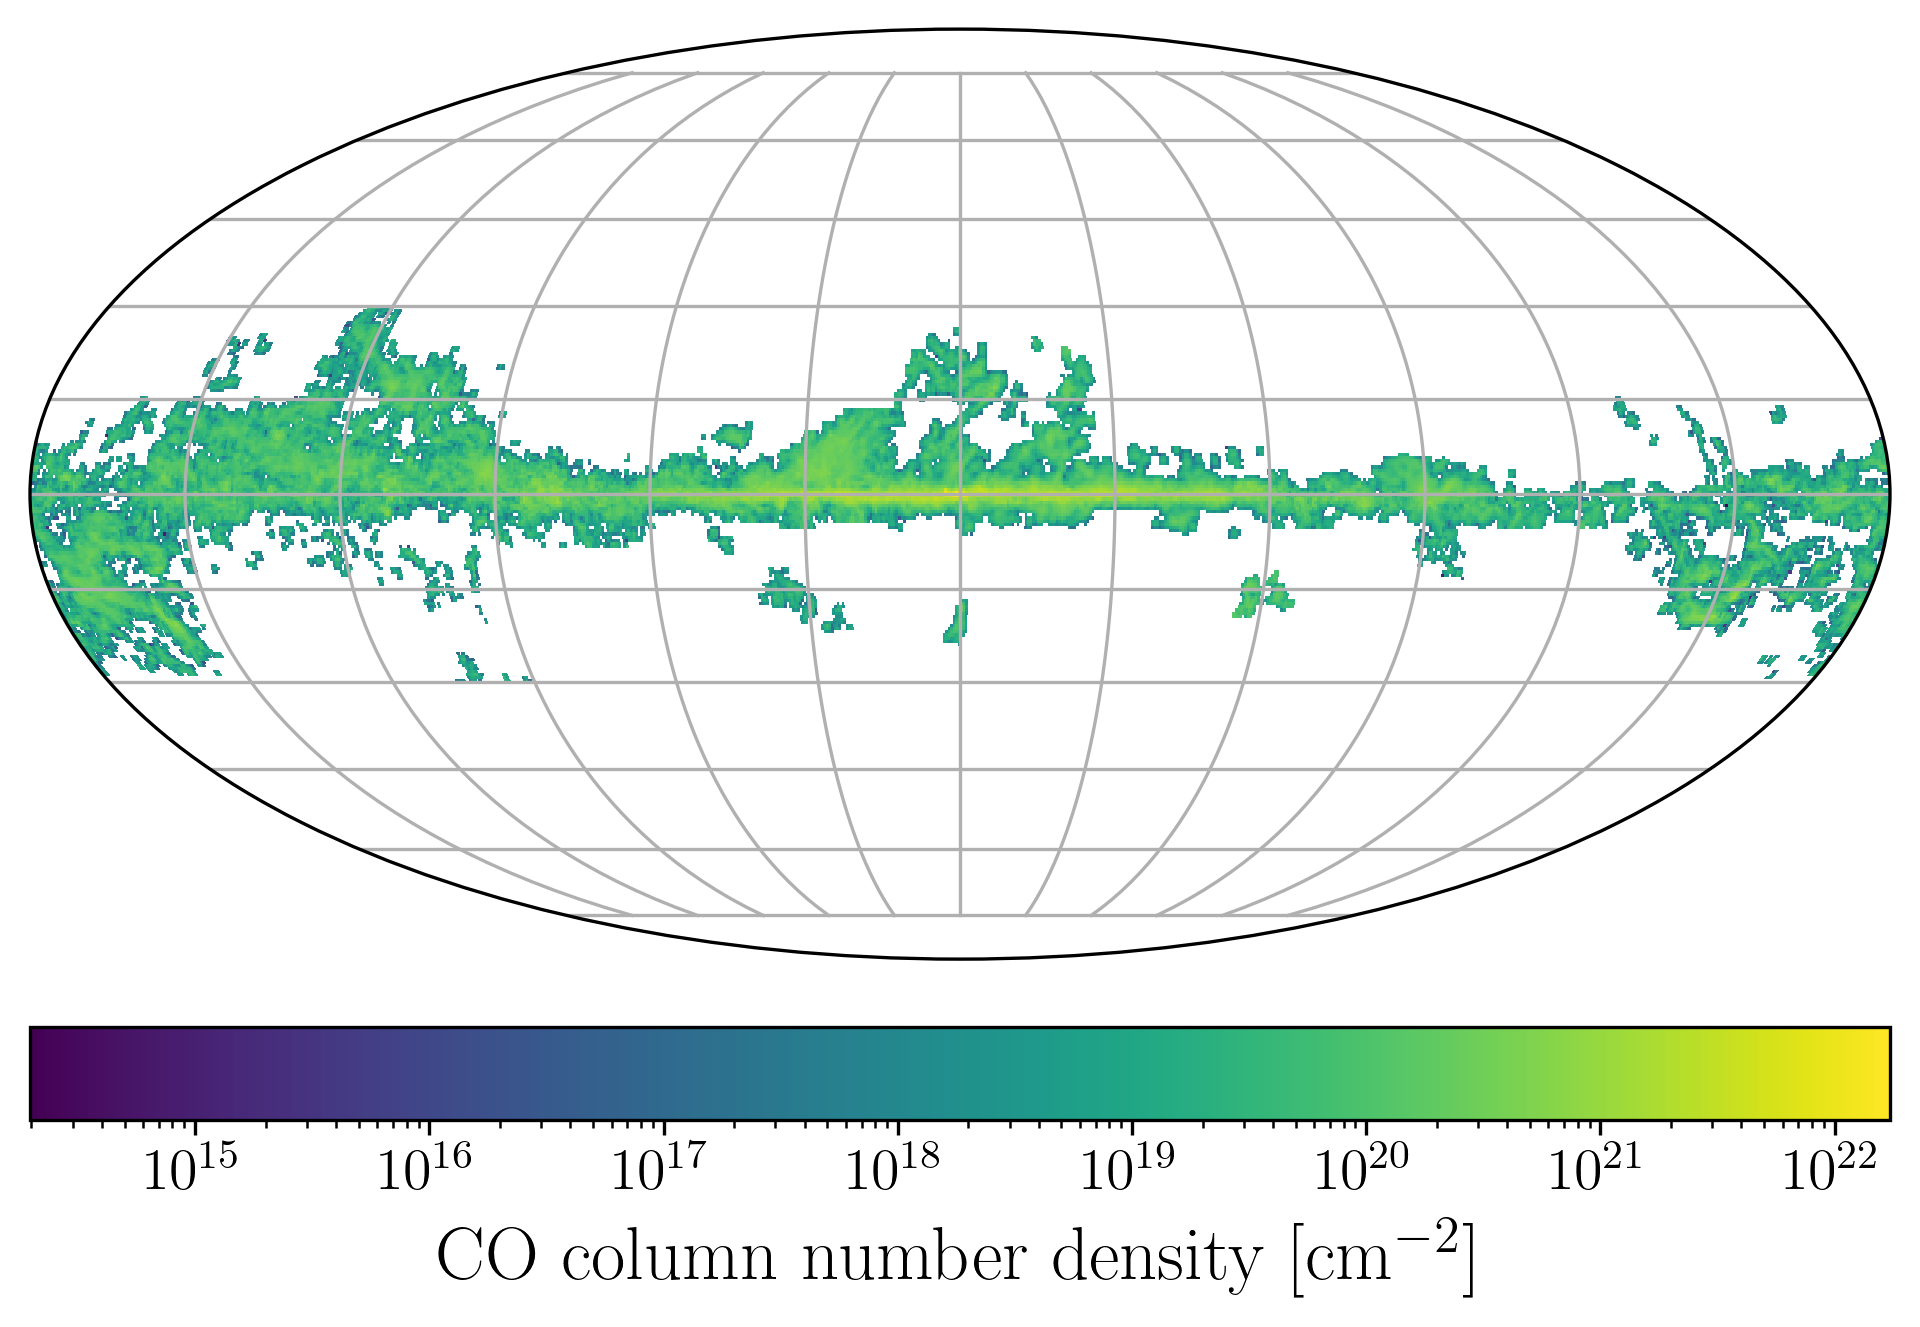

In [18]:
def plot_CO_density_map(grid, rasterized, save):
    # THIS ONE YAY
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    matplotlib.rcParams["figure.dpi"] = 300
    plt.rcParams.update({'font.size': 14})
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='mollweide')
    # convert data to kg/cm^3:
    image_concat = [hdul_CO_new[0].data[i] * r_bin_width[i] * (1/100)**3 / m_CO for i in range(9)]
    final_image = (np.sum(image_concat, axis=0).transpose() * u.kpc).to_value(u.cm)
    
    right_final_image = final_image[0:360]
    left_final_image = final_image[360:]
    
    # flip to match Planck image (https://sci.esa.int/web/planck/-/50011-all-sky-image-of-molecular-gas-seen-by-planck):
    left_final_image = final_image[360:0:-1]
    right_final_image = final_image[720:359:-1]
    
    full_final_image = np.concatenate((left_final_image, right_final_image), axis=0)
    
    ells = np.linspace(-np.pi, np.pi, 720)
    bees = np.linspace(-np.pi/2, np.pi/2, 360)
    Ells, Bees = np.meshgrid(ells, bees)
    
    im = ax.pcolormesh(Ells, Bees, full_final_image.transpose(), norm=matplotlib.colors.LogNorm(), rasterized=rasterized)
    ax.grid(grid)#, color='k')
    
    X, Y = 0.01, 0.02
    # cax = fig.add_axes([ax.get_position().x1 + X, ax.get_position().y0, 0, ax.get_position().height])
    # cax = fig.add_axes(divider.new_vertical(size='5%', pad=0.6, pack_start = True))
    # fig.add_axes(cax)
    # fig.colorbar(im, cax = cax, orientation = 'horizontal')
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.05)
    # cbar.set_label(r'Density [kg/cm$^3$]', size=14)
    cbar.set_label(r'CO column number density [cm$^{-2}$]', size=axis_label_fontsize)
    cbar.ax.tick_params()
    
    # get rid of l and b labels:
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    if save:
        plt.savefig("figures/CO_column_number_density.pdf", bbox_inches='tight')
    plt.show()

plot_CO_density_map(grid = True, rasterized = True, save = False)
